In [25]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from eval_util import make_compare_plot,plot_cdf,plot_pdf,make_prediction_diff,make_prediction,DCR, hitting_rate, make_clustering,convert_type
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
import numpy
from tqdm import tqdm
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import os
import glob
%matplotlib inline

In [3]:
def plot_pdf(data,label,bin=10):
    count, bins_count = np.histogram(data, bins=10)
    pdf = count / sum(count)

    plt.plot(bins_count[1:], pdf, label=label)

def plot_cdf(data,label,bin=10):
    count, bins_count = np.histogram(data, bins=10)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    plt.plot(bins_count[1:], cdf, label=label)

def make_compare_plot(datasets,col_name, function, names, title, dataset, additional="",save = True):
    for i in range(len(datasets)):
        data = datasets[i]
        function(data[col_name],names[i])
    plt.title(title)
    plt.legend()
    plt.grid()
    if save:
        plt.savefig("evaluation_result/{}/{}_{}.png".format(dataset,title,additional))
    plt.show()


In [26]:
dataname = "covertype"
datapath = "dataset"
generated = "{}/generated/{}/".format(datapath,dataname)


data_origin = pd.read_csv("{}/origin/{}.csv".format(datapath,dataname))

#datalist = ["ctgan","tablegan","octgan","VAE","KL_daisy","sel_daisy","sm_daisy","selgan"]


ctgan = pd.read_csv("{}/generated/{}/ctgan/ctgan_less_150.csv".format(datapath,dataname))

if (dataname =="adult") or  (dataname =="credit"):
    tablegan = pd.read_csv("{}/generated/{}/tablegan/tablegan_{}_fake.csv".format(datapath,dataname,dataname))

if not dataname == "ticket":
    octgan = pd.read_csv("{}/generated/{}/octgan/octgan_{}_less.csv".format(datapath,dataname,dataname))
    
VAE = pd.read_csv("{}/generated/{}/VAE/sample_data_vae_800_0.csv".format(datapath,dataname,dataname)).set_axis(data_origin.columns, axis=1, inplace=False)
#VAE = pd.read_csv("{}/generated/{}/ctgan/tvae_200.csv".format(datapath,dataname))
KL_daisy = pd.read_csv("{}/generated/{}/KL/KL_1_800_0.csv".format(datapath,dataname,dataname))

selgan = pd.read_csv("{}/generated/{}/selgan/selgan_300_less_batch.csv".format(datapath,dataname))
sel_daisy = pd.read_csv("{}/generated/{}/sel/sel_1_800_0.csv".format(datapath,dataname,dataname))
sm_daisy = pd.read_csv("{}/generated/{}/sel_mean/sel_mean_1_800_0.csv".format(datapath,dataname,dataname))



In [28]:
def mode_collapse(datalist,namelist):
    for i in range(len(datalist)):
        data = datalist[i]
        name = namelist[i]
        print(name, data.shape[0] - data.drop_duplicates().shape[0])

mode_collapse([ctgan,selgan,octgan,VAE],["ctgan","selgan","octgan","VAE"])

ctgan 0
selgan 0
octgan 0
VAE 0


In [6]:
save_path = "evaluation_result/{}".format(dataname)
try:
    os.mkdir(save_path)
except:
    pass

In [12]:
data_origin.columns

Index(['elevation', 'aspect', 'slope', 'hori_distance_hyd', 'vert_distance',
       'hori_distance_road', 'hillshade_9am', 'hillshade_noon',
       'hillshade_3pm', 'hori_distance_fire', 'wild_area', 'soil_type',
       'cover_type'],
      dtype='object')

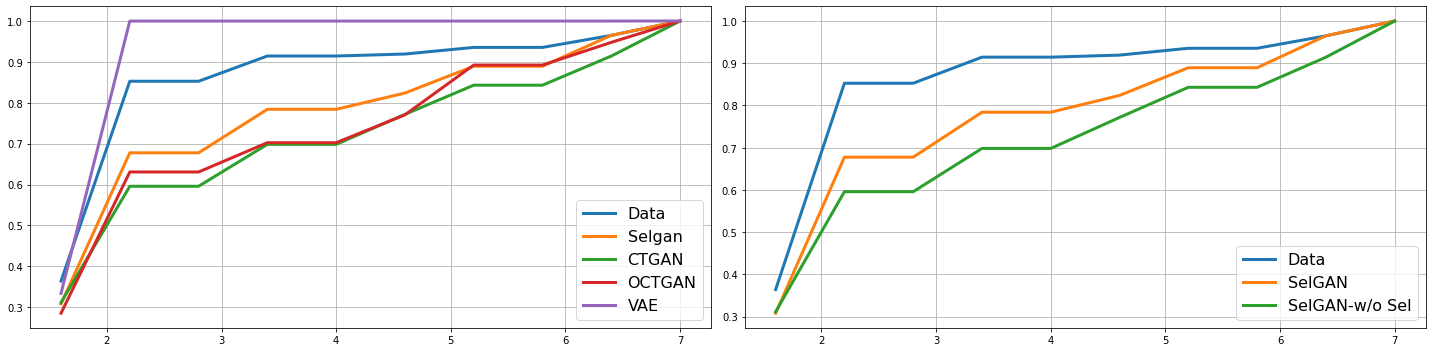

In [24]:
import matplotlib.font_manager as font_manager

column_name = "cover_type"
datasetleft = [data_origin, selgan, ctgan, octgan, VAE]
datanameleft = ["Data", "Selgan","CTGAN", "OCTGAN", "VAE"]
datasetright = [data_origin, selgan, ctgan]
datanameright = ["Data", "SelGAN", "SelGAN-w/o Sel"]

fig, (axs1,axs2) = plt.subplots(1,2, figsize = (20,5))

font = font_manager.FontProperties(
                                   #family='Comic Sans MS',
                                   #weight='bold',
                                   #style='normal', 
                                    size=16)


for i in range(len(datasetleft)):
    data = datasetleft[i][column_name]
    count, bins_count = np.histogram(data, bins=10)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    axs1.plot(bins_count[1:], cdf, label=datanameleft[i],linewidth=3)

for i in range(len(datasetright)):
    data = datasetright[i][column_name]
    count, bins_count = np.histogram(data, bins=10)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    axs2.plot(bins_count[1:], cdf, label=datanameright[i],linewidth=3)
    
axs1.legend(prop=font)
axs1.grid()
axs2.legend(prop=font)
axs2.grid()
fig.tight_layout()
        
    
# plt.subplots_adjust(left=0.1,
#                     bottom = 0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.2, 
#                     hspace=0.1)

plt.savefig("evaluation_result/{}/CDF_{}.png".format(dataname,column_name))

Index(['elevation', 'aspect', 'slope', 'hori_distance_hyd', 'vert_distance',
       'hori_distance_road', 'hillshade_9am', 'hillshade_noon',
       'hillshade_3pm', 'hori_distance_fire', 'wild_area', 'soil_type',
       'cover_type'],
      dtype='object')

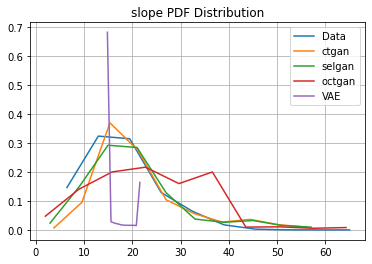

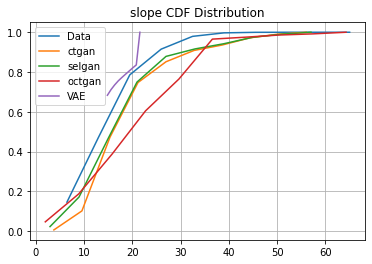

In [11]:
column_name = "slope"

make_compare_plot([data_origin, ctgan,selgan, octgan, VAE],column_name,
plot_pdf,["Data","ctgan", "selgan", "octgan", "VAE"],"{} PDF Distribution".format(column_name),dataname,"full")
make_compare_plot([data_origin, ctgan, selgan, octgan, VAE],column_name,
plot_cdf,["Data", "ctgan","selgan", "octgan", "VAE"],"{} CDF Distribution".format(column_name),dataname,"full")


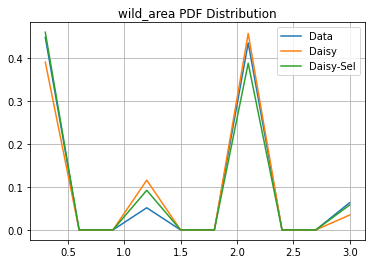

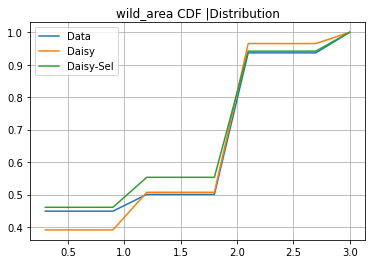

In [85]:
make_compare_plot([data_origin, KL_daisy, sel_daisy],column_name,
plot_pdf,["Data", "Daisy", "Daisy-Sel"],"{} PDF Distribution".format(column_name),dataname,"Daisy")
make_compare_plot([data_origin, KL_daisy, sel_daisy],column_name,
plot_cdf,["Data", "Daisy", "Daisy-Sel"],"{} CDF |Distribution".format(column_name),dataname,"Daisy")

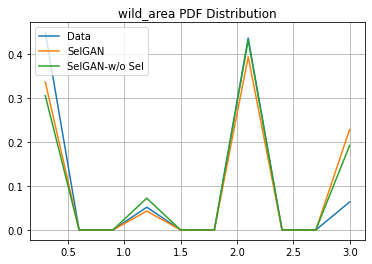

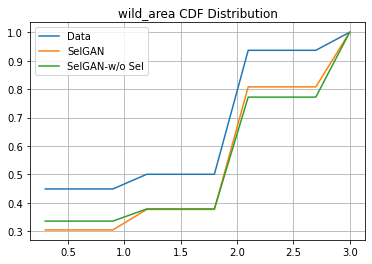

In [86]:
make_compare_plot([data_origin, selgan,ctgan],column_name,
plot_pdf,["Data", "SelGAN", "SelGAN-w/o Sel"],"{} PDF Distribution".format(column_name),dataname,"selgan")
make_compare_plot([data_origin, ctgan, selgan],column_name,
plot_cdf,["Data", "SelGAN", "SelGAN-w/o Sel"],"{} CDF Distribution".format(column_name),dataname,"selgan")

In [31]:
import scipy
import scipy.cluster.hierarchy as sch
import seaborn as sns

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

In [88]:
VAE = VAE.dropna()

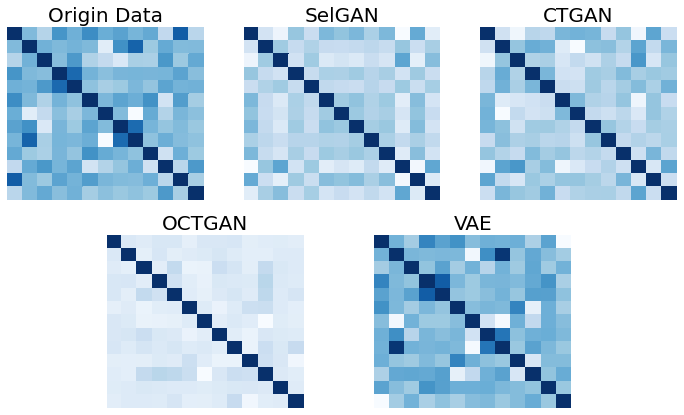

In [41]:
f,axs = plt.subplots(2,3,figsize = (12,7))

sns.heatmap(data_origin.corr(),cmap='Blues', yticklabels=False,xticklabels=False, cbar=False, ax = axs[0,0])
axs[0, 0].set_title('Origin Data', fontsize=20)

sns.heatmap((ctgan.corr()),cmap='Blues', yticklabels=False,xticklabels=False, cbar=False, ax = axs[0,1])
axs[0, 1].set_title('SelGAN', fontsize=20)

sns.heatmap((selgan.corr()),cmap='Blues', yticklabels=False,xticklabels=False, cbar=False, ax = axs[0,2])
axs[0, 2].set_title('CTGAN', fontsize=20)

sns.heatmap((octgan.corr()),cmap='Blues', yticklabels=False,xticklabels=False, cbar=False, ax = axs[1,0])
axs[1, 0].set_title('OCTGAN', fontsize=20)

# sns.heatmap((tablegan.corr()),cmap='Blues', yticklabels=False,xticklabels=False, cbar=False, ax = axs[1,1])
# axs[1, 1].set_title('tableGAN', fontsize=20)

sns.heatmap((VAE.corr()),cmap='Blues', yticklabels=False,xticklabels=False, cbar=False, ax = axs[1,1])
axs[1, 1].set_title('VAE', fontsize=20)

axs[1][2].set_visible(False)

axs[1][0].set_position([0.24,0.125,0.228,0.343])
axs[1][1].set_position([0.55,0.125,0.228,0.343])

plt.savefig("evaluation_result/{}/CompleteHeatmap.png".format(dataname,"Origin Data"))
plt.show()

In [42]:
print("octgan",abs(data_origin.corr() - octgan.corr()).sum().sum())
print("selgan",abs(data_origin.corr() - ctgan.corr()).sum().sum())
print("ctgan",abs(data_origin.corr() - selgan.corr()).sum().sum())
#print("tablegan",abs(data_origin.corr() - tablegan.corr()).sum().sum())
print("vae",abs(data_origin.corr() - VAE.corr()).sum().sum())

octgan 26.961090599677217
selgan 19.790536976585393
ctgan 21.947792837766695
vae 15.99071012277161


## Evaluation

#### Convert data type

In [3]:
import json

with open(datapath +"/configeration/" +dataname+"_config.json", 'r') as f:
    config = json.load(f)

In [4]:
categoricals = config["one-hot_cols"]
ordinals = config["ordinal_cols"]

#coverted_train = convert_type(train, categoricals+ordinals)

In [68]:
ordinals

[]

In [10]:
#sorted(categoricals+ordinals)

In [27]:
# tablegan没有income 所以不参加

data_origin["label"] = "data"


# ctgan["label"] = "ctgan"
# selgan["label"] = "selgan"
# octgan["label"] = "octgan"

# VAE["label"] = "VAE"
KL_daisy["label"] = "KL"
sel_daisy["label"] = "sel"
sm_daisy["label"] = "sm"



In [28]:
full = pd.concat([data_origin,ctgan,selgan,octgan,VAE,KL_daisy,sel_daisy,sm_daisy])
full = full[data_origin.columns]
full = convert_type(full,sorted(categoricals+ordinals))

my col_list [10, 11, 12]


#### Split train and test

In [29]:
data_origin_droped = data_origin.drop(columns=["label"]).astype("float64")
origin_np = np.array(data_origin_droped)
col = list(data_origin_droped.columns)
indices = numpy.random.permutation(data_origin.shape[0])
n = int(data_origin.shape[0] * 0.3)
test_idx, training_idx = indices[:n], indices[n:]
training_data, test = pd.DataFrame(origin_np[training_idx,:],columns = col), pd.DataFrame(origin_np[test_idx,:],columns = col)
#training_data = training_data.drop(columns=["label","fnlwgt","income"]).astype("float64")

In [16]:
sm_daisy

,elevation,aspect,slope,hori_distance_hyd,vert_distance,hori_distance_road,hillshade_9am,hillshade_noon,hillshade_3pm,hori_distance_fire,wild_area,soil_type,cover_type,label
0,3077.0,321.0,21.0,302.0,181.0,1900.0,145.0,221.0,187.0,1717.0,2,1,0,sm
1,2992.0,124.0,22.0,373.0,53.0,1733.0,151.0,250.0,203.0,1989.0,2,9,1,sm
2,2954.0,341.0,4.0,267.0,12.0,3019.0,206.0,230.0,177.0,2701.0,0,20,1,sm
3,2984.0,244.0,20.0,254.0,61.0,4292.0,174.0,229.0,215.0,2020.0,0,27,1,sm
4,3040.0,325.0,16.0,536.0,-7.0,1855.0,167.0,192.0,134.0,2088.0,2,4,0,sm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69717,3037.0,335.0,15.0,221.0,57.0,4028.0,170.0,229.0,210.0,2086.0,0,27,0,sm
69718,3174.0,251.0,5.0,816.0,154.0,3196.0,203.0,246.0,168.0,2076.0,0,31,1,sm
69719,2871.0,22.0,16.0,206.0,54.0,752.0,218.0,199.0,127.0,1568.0,2,12,0,sm
69720,3237.0,269.0,9.0,46.0,26.0,2396.0,224.0,246.0,160.0,2107.0,0,36,1,sm


In [43]:

# distorsions = []
# for k in range(2, 20):
#     kmeans = KMeans(n_clusters=k)
#     kmeans.fit(X)
#     distorsions.append(kmeans.inertia_)

# fig = plt.figure(figsize=(15, 5))
# plt.plot(range(2, 20), distorsions)
# plt.grid(True)

# plt.title('Elbow curve')
# plt.show()

In [30]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

def make_prediction(response, response_type,training_data, test, dataset, clf):

    f1 = []
    auc = []
    mse = []
    result = []

    train_data_y = training_data[response].astype("float64")
    train_data_X = training_data.drop(columns=[response]).astype("float64")

    test_data_X = test.drop(columns=[response]).astype("float64")
    test_data_y = test[response].astype("float64")


    clf.fit(train_data_X, train_data_y)
    pred_data_y = clf.predict(test_data_X)
    result.append(clf.score(test_data_X,test_data_y))
    
    
    if response_type == "clf":
        f1.append(f1_score(test_data_y, pred_data_y
                           ,average='weighted'))
        
    else:
        mse.append(((pred_data_y-test_data_y)**2).mean())


    for data in tqdm(dataset):

        train_X = data.drop(columns=[response,"label"]).astype("float64")
        train_y = data[response].astype("float64")
        
        #try:
        clf.fit(train_X, train_y)
        pred_data_y = clf.predict(test_data_X)
        #except:
        #    result.append(np.nan)
            
        if response_type == "clf":
            result.append(clf.score(test_data_X,test_data_y))
            f1.append(f1_score(test_data_y, pred_data_y
                               ,average='weighted'))      
            
        else:
            result.append(clf.score(test_data_X,test_data_y))
            mse.append(((pred_data_y-test_data_y)**2).mean())

    if response_type == "clf":       
        return result,f1
    else:
        return result,mse

In [31]:
dataset = [ctgan,selgan,octgan,VAE]
dataset = [KL_daisy,KL_daisy,sm_daisy]
#dataset = [ctgan]

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR

from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier


xgb_clf = xgb.XGBClassifier(eval_metric='mlogloss')
xgb_reg = xgb.XGBRegressor(eval_metric='mlogloss')

rf_clf = RandomForestClassifier()
rf_reg = RandomForestRegressor()

svm_clf = LinearSVC()
svm_reg = LinearSVR()

In [34]:
acc_xgb, f1_xgb = make_prediction("cover_type", "clf",training_data, test,dataset,xgb_clf)
acc_rf, f1_rf = make_prediction("cover_type", "clf",training_data, test,dataset,rf_clf)
acc_svm, f1_svm = make_prediction("cover_type", "clf",training_data, test,dataset,svm_clf)

100%|██████████| 3/3 [01:48<00:00, 36.21s/it]


In [36]:
ct_f1 = pd.DataFrame({"XGB":f1_xgb,"RF":f1_rf,"SVM":f1_svm},index = ["Origin","KL_Daisy","Sel-Daisy","SM_Daisy"])
ct_f1["avg"] = ct_f1.mean(axis=1)

# ct_acc = pd.DataFrame({"XGB":acc_xgb,"RF":acc_rf,"SVM":acc_svm},index = ["Origin","KL_Daisy","Sel-Daisy","SM_Daisy"])
# ct_acc["avg"] = ct_acc.mean(axis=1)

In [37]:
ct_f1

,XGB,RF,SVM,avg
Origin,0.845098,0.886824,0.502309,0.744744
KL_Daisy,0.488600,0.521676,0.417348,0.475874
Sel-Daisy,0.488600,0.542955,0.449005,0.493520
SM_Daisy,0.533262,0.545144,0.510792,0.529733


In [18]:
ct_f1 = pd.DataFrame({"XGB":f1_xgb,"RF":f1_rf,"SVM":f1_svm},index = ["Origin","CTGAN","Selgan","octgan","VAE"])
ct_f1["avg"] = ct_f1.mean(axis=1)

ct_acc = pd.DataFrame({"XGB":acc_xgb,"RF":acc_rf,"SVM":acc_svm},index = ["Origin","CTGAN","Selgan","octgan","VAE"])
ct_acc["avg"] = ct_acc.mean(axis=1)

In [14]:
sp = pd.DataFrame({"XGB":sp_mse_xgb,"RF":sp_mse_rf,"SVM":sp_mse_svm},index = ["Origin","CTGAN","Selgan","octgan","VAE"])
sp["avg"] = sp.mean(axis=1)
sp

,XGB,RF,SVM,avg
Origin,22.800817,16.261902,108.054865,49.039195
CTGAN,78.058888,78.800462,584.318755,247.059368
Selgan,73.484806,77.946439,158.403929,103.278391
octgan,98.894341,100.022460,150.612753,116.509851
VAE,134.933743,102.812523,240.306948,159.351071


In [24]:
ct_f1.to_csv("covertype_covertype_f1.csv")

In [15]:
sp.to_csv("covertype_soiltype_mse.csv")

In [38]:
sp_r2_xgb, sp_mse_xgb = make_prediction("soil_type", "reg",training_data, test,dataset,xgb_reg)
sp_r2_rf, sp_mse_rf = make_prediction("soil_type", "reg",training_data, test,dataset,rf_reg)
sp_r2_svm, sp_mse_svm = make_prediction("soil_type", "reg",training_data, test,dataset,svm_reg)


100%|██████████| 3/3 [00:28<00:00,  9.65s/it]


In [39]:
sp = pd.DataFrame({"XGB":sp_mse_xgb,"RF":sp_mse_rf,"SVM":sp_mse_svm},index = ["Origin","KL_Daisy","Sel-Daisy","SM_Daisy"])
sp["avg"] = sp.mean(axis=1)
sp


,XGB,RF,SVM,avg
Origin,23.233705,16.695288,85.295868,41.741621
KL_Daisy,130.119652,127.890495,525.570952,261.193700
Sel-Daisy,130.119652,126.331456,173.649244,143.366784
SM_Daisy,110.464883,92.381395,131.815179,111.553819


In [98]:
make_prediction("cover_type", "clf",training_data, test,dataset)

100%|██████████| 4/4 [01:39<00:00, 24.87s/it]


([0.8486660929432014,
  0.43868330464716004,
  0.4656196213425129,
  0.33545611015490534,
  0.6445783132530121],
 [0.8470530137900122,
  0.43322852328718536,
  0.47754051565393346,
  0.2938861347959207,
  0.5987043932264462])

In [18]:
make_prediction("soil_type", "reg",training_data, test,dataset)

100%|██████████| 4/4 [00:16<00:00,  4.20s/it]


[21.74607722541128,
 72.74850249013353,
 67.84731114879318,
 90.69081718452908,
 137.82463157388588]

In [17]:
make_prediction("hillshade_3pm", "reg",training_data, test,dataset)

100%|██████████| 4/4 [08:42<00:00, 130.53s/it]


([0.7329173838209982,
  0.14505163511187608,
  0.18679001721170396,
  0.05086058519793459,
  0.2800774526678141],
 [0.7275916159866304,
  0.13602419385150005,
  0.16316088739521686,
  0.05802280984640583,
  0.20697440465880665])

In [19]:
make_prediction("wild_area", "clf",training_data, test,dataset)

100%|██████████| 4/4 [01:05<00:00, 16.46s/it]


([0.9821858864027538,
  0.6990533562822719,
  0.6199655765920826,
  0.4099397590361446,
  0.6608003442340792],
 [0.9821766253959215,
  0.6801650429126923,
  0.6157027543112112,
  0.3974531264394327,
  0.6361319600308858])

In [20]:
make_prediction("elevation", "reg",training_data, test,dataset)

100%|██████████| 4/4 [00:18<00:00,  4.56s/it]


[6971.247833928784,
 45232.599055219085,
 48966.9917136615,
 97107.54968575943,
 75783.6840400609]

In [21]:
make_prediction("aspect", "reg",training_data, test,dataset)

100%|██████████| 4/4 [00:16<00:00,  4.03s/it]


[58.50712500065875,
 12329.246064422221,
 12063.829867694736,
 26165.128508467445,
 7133.972457991542]

In [22]:
make_prediction("slope", "reg",training_data, test,dataset)

100%|██████████| 4/4 [00:16<00:00,  4.16s/it]


[0.20732208279072073,
 56.739994553068925,
 56.3060235444841,
 77.33191403569784,
 49.85186013524418]

In [23]:
make_prediction("hori_distance_hyd", "reg",training_data, test,dataset)

100%|██████████| 4/4 [00:16<00:00,  4.14s/it]


[10332.590728286883,
 48575.67175319112,
 49560.452177290375,
 49077.226350777346,
 34546.823528966044]

In [24]:
make_prediction("vert_distance", "reg",training_data, test,dataset)

100%|██████████| 4/4 [00:16<00:00,  4.10s/it]


[1090.227961406895,
 3659.0184248689006,
 3550.379079660066,
 11243.906137907848,
 2676.0110522335144]

In [25]:
make_prediction("hori_distance_road", "reg",training_data, test,dataset)

100%|██████████| 4/4 [00:16<00:00,  4.13s/it]


[617858.6070377157,
 2104981.9188774214,
 2134277.754277056,
 4636920.278761279,
 2465302.8721551406]

In [26]:
make_prediction("hillshade_9am", "reg",training_data, test,dataset)

100%|██████████| 4/4 [00:16<00:00,  4.07s/it]


[0.5075161273348596,
 653.3557807059178,
 600.4395819305038,
 865.7411195306595,
 622.6735607204273]

In [27]:
make_prediction("hillshade_noon", "reg",training_data, test,dataset)

100%|██████████| 4/4 [00:16<00:00,  4.02s/it]


[0.4223913954110237,
 372.4276812973213,
 359.42202519474813,
 544.1383316521373,
 278.36672587578437]

In [28]:
make_prediction("hillshade_3pm", "reg",training_data, test,dataset)

100%|██████████| 4/4 [00:16<00:00,  4.06s/it]


[7.678199035620947,
 1428.0065177357674,
 1107.366237030323,
 1954.2423614733318,
 905.9058774670071]

In [29]:
make_prediction("hori_distance_fire", "reg",training_data, test,dataset)

100%|██████████| 4/4 [00:16<00:00,  4.04s/it]


[600862.5726040159,
 1758783.9251644837,
 1775866.0296391442,
 2490336.4801228642,
 1873044.1654448528]

its:7 col
full:7 col

In [44]:
def make_clustering(training_data,test,dataset,n = 3):
    NMI = []

    train_data_x = training_data.astype("float64")

    test_data_X = test.astype("float64")
    
    kmeans = KMeans(n_clusters=n, random_state=0).fit(train_data_x)

    ground_truth = kmeans.predict(test_data_X)

    NMI.append(normalized_mutual_info_score(ground_truth, ground_truth))
    #print(train_data_x.columns)

    for data in dataset:
        data = data.drop(columns=["label"]).astype("float64")
        #print(data.columns)
        kmeans = KMeans(n_clusters=n, random_state=0).fit(data)
        result = kmeans.predict(test_data_X)
        NMI.append(normalized_mutual_info_score(ground_truth, result))




    return NMI
### Clustering

In [43]:
## Unsupervised Machine learning task 

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
pd.DataFrame(make_clustering(training_data,test,dataset),index=["ground Truth",'ctgan','selgan','octgan','VAE'],columns=["Clustering NMI"])

,Clustering NMI
ground Truth,1.000000
ctgan,0.720969
selgan,0.545670
octgan,0.437389
VAE,0.536479


## Loss 

In [ ]:
data_log = pd.read_csv("dataset/generated/strong_cate/full/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('strong_cate_full training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/weak_cate/full/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('weak_cate_full training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/weak_num/full/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('weak_num_full training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/strong_num/full/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('strong_num_full training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/strong_cate/its/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('strong_cate_its training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/weak_cate/its/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('weak_cate_its training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/weak_num/its/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('weak_num_its training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/strong_num/its/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('strong_num_its training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

### Approximate query processing (AQP)

AQP 
* http://dbgroup.cs.tsinghua.edu.cn/ligl/baq.pdf 
* https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9101822


### Privacy protection

#### Hitting Rate & DCR

In [ ]:
len(dataset)

In [ ]:
similar = hitting_rate(dataset)

In [ ]:
maxi,mini = DCR(dataset)


In [ ]:
pd.DataFrame(np.array([similar,maxi,mini]).T,index=["Origin GAN","Strong-Num_its","Weak-Num_its","Strong-Cate_its","Weak-Cate_its","Strong-Num_full","Weak-Num_full","Strong-Cate_full","Weak-Cate_full"],columns=["Exactly Same data (Categorical)","Distance to the furthest record","Distance to the closest record"])